# Jeremy Bailin's solution to the [March 10, 2023 riddler](https://fivethirtyeight.com/features/how-fast-can-you-make-the-track/).

"While passing the time at home one evening, you decide to set up a marble race course. No Teflon is spared, resulting in a track that is effectively frictionless.

The start and end of the track are 1 meter apart, and both positions are 10 centimeters off the floor. It’s up to you to design a speedy track. But the track must always be at floor level or higher — please don’t dig a tunnel through your floorboards.

What’s the fastest track you can design, and how long will it take the marble to complete the course?"

## Answer

Read the full document for analysis, but the quick version is that my entry is:

$$ f(x) = \begin{cases}  0.1 & x=0 \\ A \exp \left(-\frac{x}{A} \cosh\left(\frac{x}{B}\right) \right) & 0 < x \le 0.5 \\
A \exp \left(-\frac{1-x}{A} \cosh\left(\frac{1-x}{B}\right) \right)  & 0.5 < x < 1 \\ 0.1 & x=1 \end{cases} $$

with $A=0.08076$ and $B=0.07718$, which has a total time of 0.9468 seconds.

## First thoughts: analytic solution?

My original thought was that there would be a nice calculus-of-variations style solution. That didn't work, but it's worth showing the relevant diff.eq. Since there's no friction, we can use simple Lagrangian mechanics. If we assume that the height of the course at point $x$ is $y=f(x)$, then

$$ T = \frac{1}{2} m \dot{x}^2 + \frac{1}{2} m \dot{y}^2$$
$$ = \frac{1}{2} m \dot{x}^2 + \frac{1}{2} m \dot{x}^2 \left(\frac{df}{dx}\right)^2 $$

$$ V = mgy = m g f(x) $$

$$ L = T - V = \frac{1}{2} m \dot{x}^2 + \frac{1}{2} m \dot{x}^2 \left(\frac{df}{dx}\right)^2 - m g f(x) $$

The Euler-Lagrange equation of motion here is

$$ \frac{d}{dt} \left( \frac{\partial L}{\partial \dot{x}} \right) = \frac{\partial L}{\partial x} $$
Taking all the derivatives, we end up with

$$ \ddot{x} \left[1 + \left(\frac{df}{dx}\right)^2\right] + \dot{x} \left(\frac{df}{dx}\right) \left(\frac{d^2f}{dx^2}\right) + g \left(\frac{df}{dx}\right) = 0 $$

Ideally one would then be able to set up an equation where you integrate the $x$ parts of the equation from 0 to 1 and the $t$ parts from 0 to the total time $t_{tot}$, then take the derivative with respect to $t_{tot}$, set that equal to 0 to find the minimum, and that would give a useful diff.eq for $f(x)$ that one could solve analytically.

I was not able to get that to work. So I went with a numerical approach.

## Numerical approach

If we sample $f(x)$ on a grid of $x$ from 0 to 1, then we can use some basic kinematics to solve for the marble's motion along each segment and at each kink, and numerically integrate the path.

### Along a segment

Specifically, we can break the motion down to segment motion, where it travels from $x_0$ to $x_1$ in $x$ and $y_0 = f(x_0)$ to $y_1 = f(x_1)$ in $y$. Keeping everything in terms of $x$, we find that the acceleration in the $x$ direction over this segment is

$$ a_x = \frac{g k}{1 + k^2} $$
where we define $k \equiv -\frac{df}{dx} = \frac{y_0 - y_1}{x_1 - x_0}$.

If the time it takes to traverse the segment is $\Delta t$, and the velocity at the beginning of the segment is $v_{x0}$ then at the end of the segment it will have increased to
$$ v_{x1} = v_{x0} + a_x \Delta t = v_{x0} + \frac{g k}{1 + k^2} $$

The distance in $x$ that is traveled is $\Delta x = v_{x0} \Delta t + \frac{1}{2} a_x (\Delta t)^2 $, which is known because it's the distance between points on the $x$ grid we set up. This therefore gives us a quadratic equation for $\Delta t$; the relevant solution is

$$ \Delta t = \frac{-v_{x0} + \sqrt{v_{x0}^2 + 2 (\Delta x) g k / (1 + k^2)}}{g k / (1 + k^2)} $$

### At kinks

The track is frictionless, so energy is conserved. At the kink, potential energy isn't changing, so kinetic energy must be conserved. Noting that on any segment, the components of the velocity are related by $v_y = v_x k$, we can set $\frac{1}{2} m (v_{x0}^2 + v_{y0}^2) = \frac{1}{2} m (v_{x1}^2 + v_{y1}^2)$, or
$$ v_{x1} = v_{x0} \sqrt{\frac{1 + k_0^2}{1 + k_1^2}} $$


### Implementation

Great! Here's a function that takes a set of samples (excluding the first and last ones, which have to be at 0.1) and integrates the path of the marble across them, and figures out the total time.

In [1]:
import numpy as np
from scipy import integrate, interpolate

In [2]:
TOOLARGE = 1e11
height = 0.1

def find_time_interval(fsamples_between, savearrays=False):
    Nsamples_between = len(fsamples_between)
    # Stick a 0.1 and beginning and end
    fsamples = np.concatenate(([height], fsamples_between, [height]))
    Nsamples = len(fsamples)
    L = 1.0
    dx = L / (Nsamples-1)
    xsamples = np.linspace(0, L, Nsamples)
    g = 9.8
    t0 = 0.
    x0 = 0.
    xprime0 = 0.
    
    k = -(fsamples[1:] - fsamples[:-1]) / dx
    tarray = [t0]
    vxarray = [xprime0]
    yarray = [fsamples[0]]
    vxnow = xprime0
    tnow = t0
    for i in range(Nsamples-1):
        # First do linear segment
        # if k is 0, use dt = dx/v
        if k[i] == 0.:
            # If vx is zero, it's going nowhere. Return a VERY LARGE NUMBER.
            if vxnow==0.:
                if savearrays:
                    return TOOLARGE, tarray, xsamples, fsamples, vxarray
                else:
                    return TOOLARGE
            else:
                dt = dx / vxnow
        else:
            # If it goes literally back to the top, the argument to the sqrt
            # can become a tiny bit negative. In that case, assume it's zero
            quad_sqrt_argument = vxnow**2 + 2.*dx*g*k[i]/(1. + k[i]*k[i])
            if quad_sqrt_argument < 0.:
                quad_sqrt_argument = 0.
            dt = (-vxnow + np.sqrt(quad_sqrt_argument)) / (g*k[i]/(1. + k[i]*k[i]))
            if dt==0.:
                # This happens when k isn't exactly 0, but low enough that it causes an underflow.
                # Treat like k=0 case
                if vxnow==0.:
                    if savearrays:
                        return TOOLARGE, tarray, xsamples, fsamples, vxarray
                    else:
                        return TOOLARGE
                else:
                    dt = dx / vxnow
        tnow += dt
        vx0 = vxnow + g*k[i]/(1. + k[i]*k[i]) * dt
    
        # Update velocity using conservation of kinetic energy at the kink (except at endpoint)
        if i < Nsamples-2:
            vxnow = vx0 * np.sqrt( (1.+k[i]*k[i]) / (1.+k[i+1]*k[i+1]) )
        else:
            vxnow = vx0

        if savearrays:
            tarray.append(tarray[-1]+dt)
            vxarray.append(vxnow)
        
        tottime = tnow
        
    if savearrays:
        return tottime, np.array(tarray), xsamples, fsamples, np.array(vxarray)
    else:
        return tottime

Let's give it a simple test case where the track drops linearly to the midpoint, then back up again.

In [3]:
xg = np.linspace(0., 1.0, 50)
fsamples_guess = 1.94*height*np.abs(xg-0.5)

ttxf = find_time_interval(fsamples_guess, savearrays=True)
ttxf_linear = ttxf

print(f"Total time: {ttxf[0]}")

Total time: 1.5205210518885153


In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


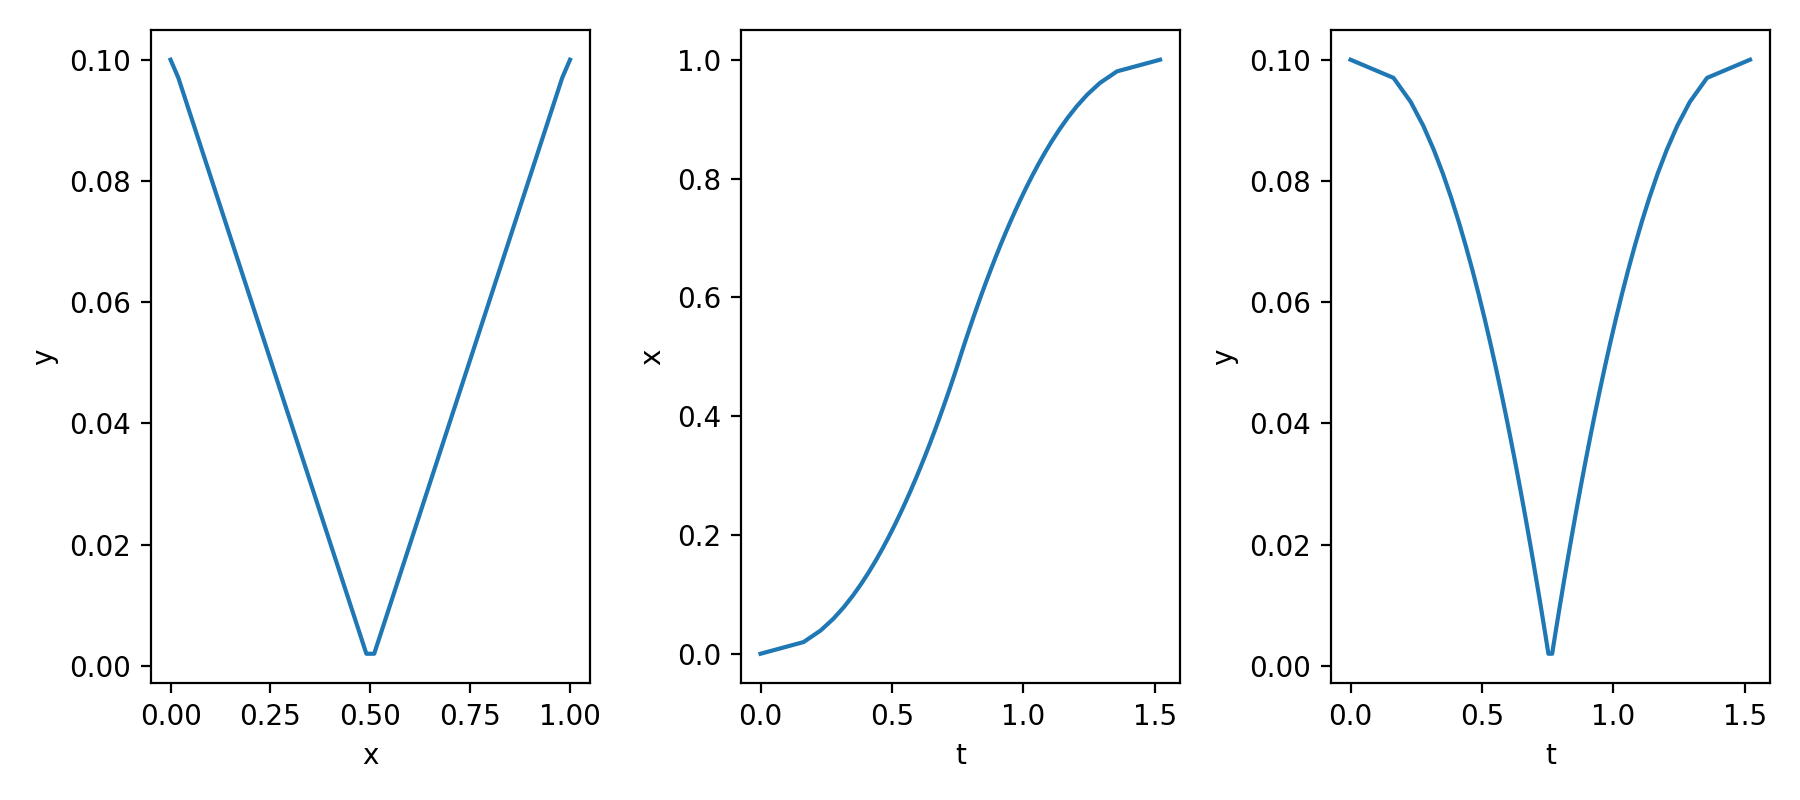

In [5]:
fig, axes = plt.subplot_mosaic("ABC", figsize=(9,4))
axes['A'].plot(ttxf[2], ttxf[3])
axes['A'].set_xlabel('x')
axes['A'].set_ylabel('y')
axes['B'].plot(ttxf[1], ttxf[2])
axes['B'].set_xlabel('t')
axes['B'].set_ylabel('x')
axes['C'].plot(ttxf[1], ttxf[3])
axes['C'].set_xlabel('t')
axes['C'].set_ylabel('y')
fig.tight_layout()

Looks good! Now let's do a minimization with respect to total time.

In [6]:
from scipy.optimize import minimize

In [7]:
result = minimize(find_time_interval, fsamples_guess, bounds=[[0.,height]]*len(fsamples_guess))
ttxf = find_time_interval(result.x, savearrays=True)
print(f"Optimized time: {ttxf[0]}")

Optimized time: 0.9442427584416079


Yup, that's faster! Let's see what it looks like.

<IPython.core.display.Javascript object>


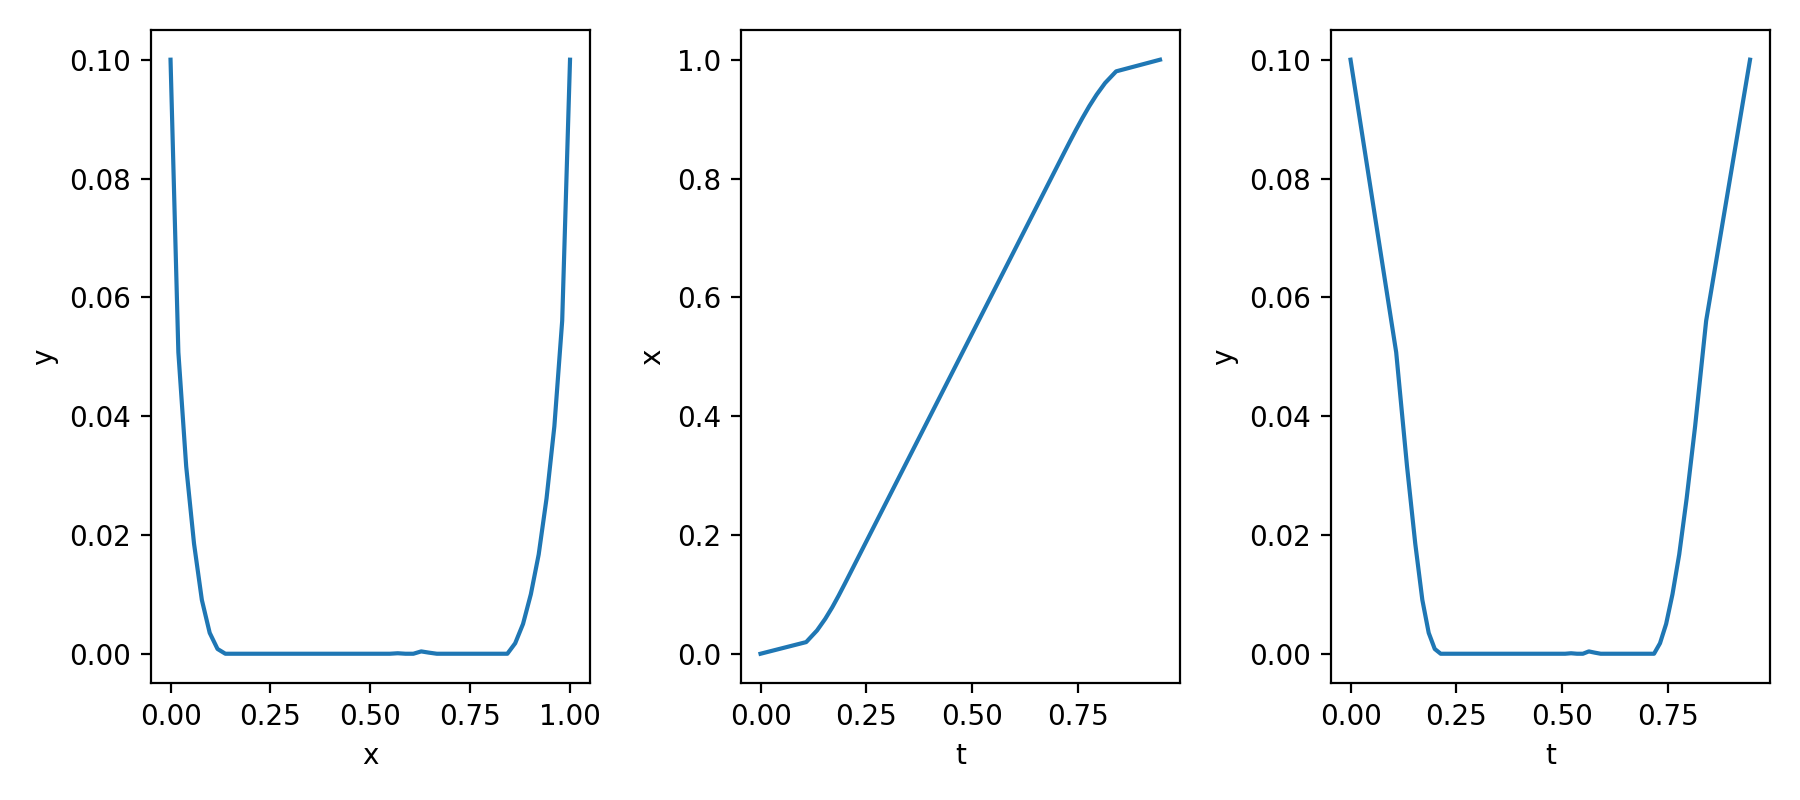

In [8]:
fig, axes = plt.subplot_mosaic("ABC", figsize=(9,4))
axes['A'].plot(ttxf[2], ttxf[3])
axes['A'].set_xlabel('x')
axes['A'].set_ylabel('y')
axes['B'].plot(ttxf[1], ttxf[2])
axes['B'].set_xlabel('t')
axes['B'].set_ylabel('x')
axes['C'].plot(ttxf[1], ttxf[3])
axes['C'].set_xlabel('t')
axes['C'].set_ylabel('y')
fig.tight_layout()

Interesting -- clearly getting down to the bottom ASAP to build up speed is a good idea... but it doesn't drop striaght to 0 on the first grid point.

To get a better pictures, we should use more grid points. Probably best to use a higher resolution version of this as an initial guess since it will be closer to the correct solution.

In [9]:
Nnew = 2000
N50_guess = result.x
x50 = np.linspace(0,1,50)
x2000 = np.linspace(0,1,2000)
interp_func = interpolate.interp1d(x50, N50_guess)
N2000_guess = interp_func(x2000)

In [10]:
# Let's make sure that we get basically the same answer using the higher resolution version.

ttxf = find_time_interval(N2000_guess, savearrays=True)

print(f"Total time: {ttxf[0]}")

Total time: 0.9549007313725449


<IPython.core.display.Javascript object>


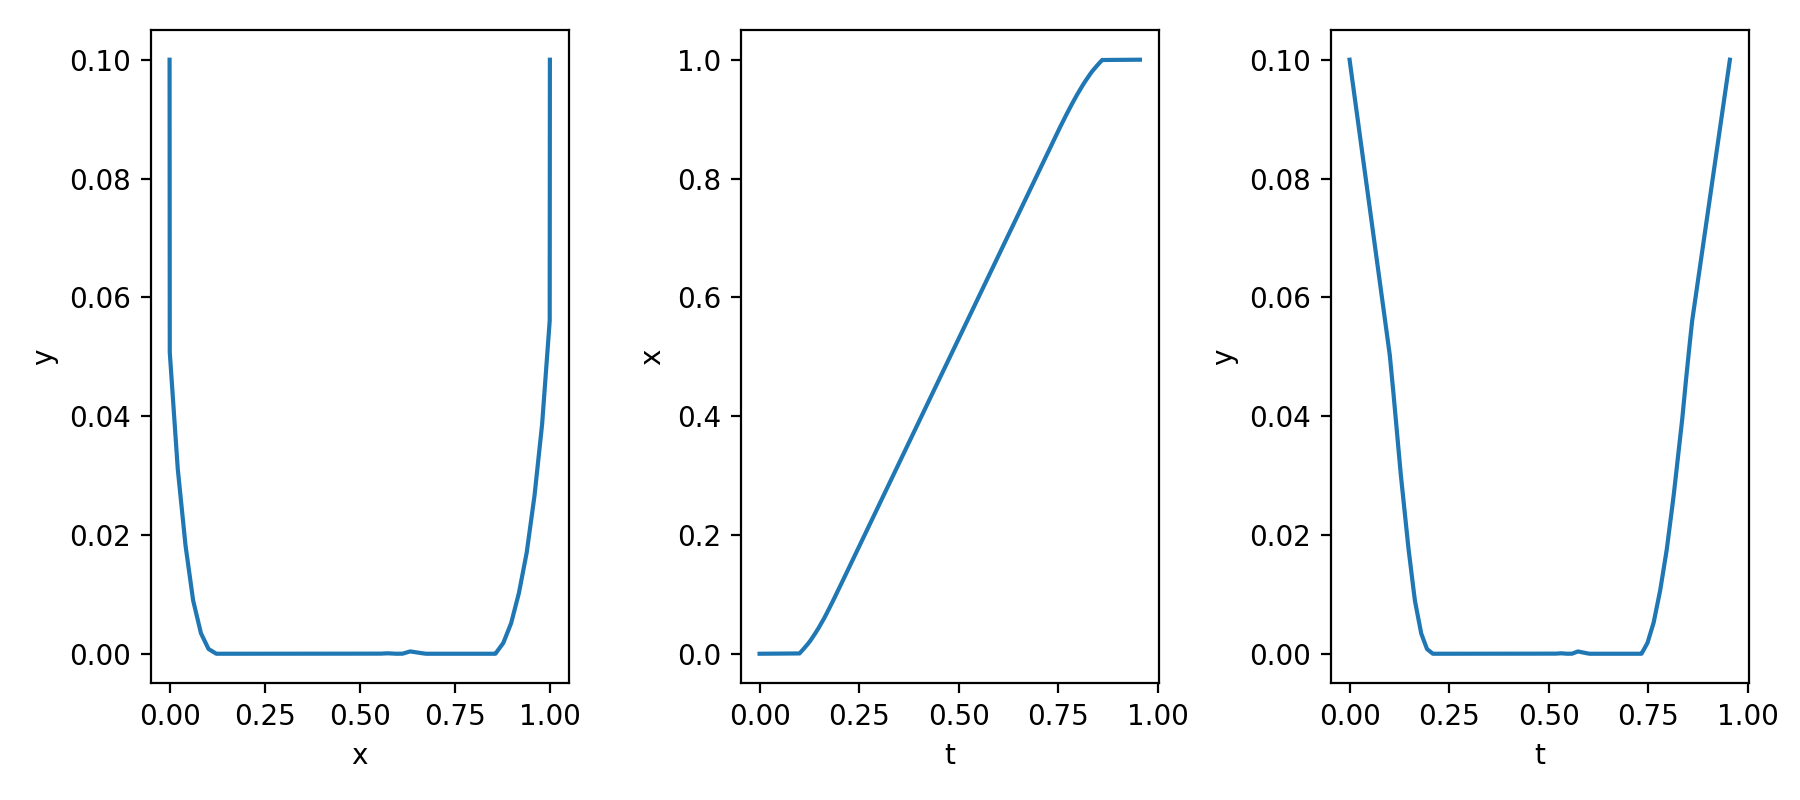

In [11]:
fig, axes = plt.subplot_mosaic("ABC", figsize=(9,4))
axes['A'].plot(ttxf[2], ttxf[3])
axes['A'].set_xlabel('x')
axes['A'].set_ylabel('y')
axes['B'].plot(ttxf[1], ttxf[2])
axes['B'].set_xlabel('t')
axes['B'].set_ylabel('x')
axes['C'].plot(ttxf[1], ttxf[3])
axes['C'].set_xlabel('t')
axes['C'].set_ylabel('y')
fig.tight_layout()

Yup! Time to optmimize.

In [12]:
result = minimize(find_time_interval, N2000_guess, bounds=[[0.,height]]*len(N2000_guess))
ttxf = find_time_interval(result.x, savearrays=True)
print(f"Optimized time: {ttxf[0]}")

Optimized time: 0.9544397608611782


<IPython.core.display.Javascript object>


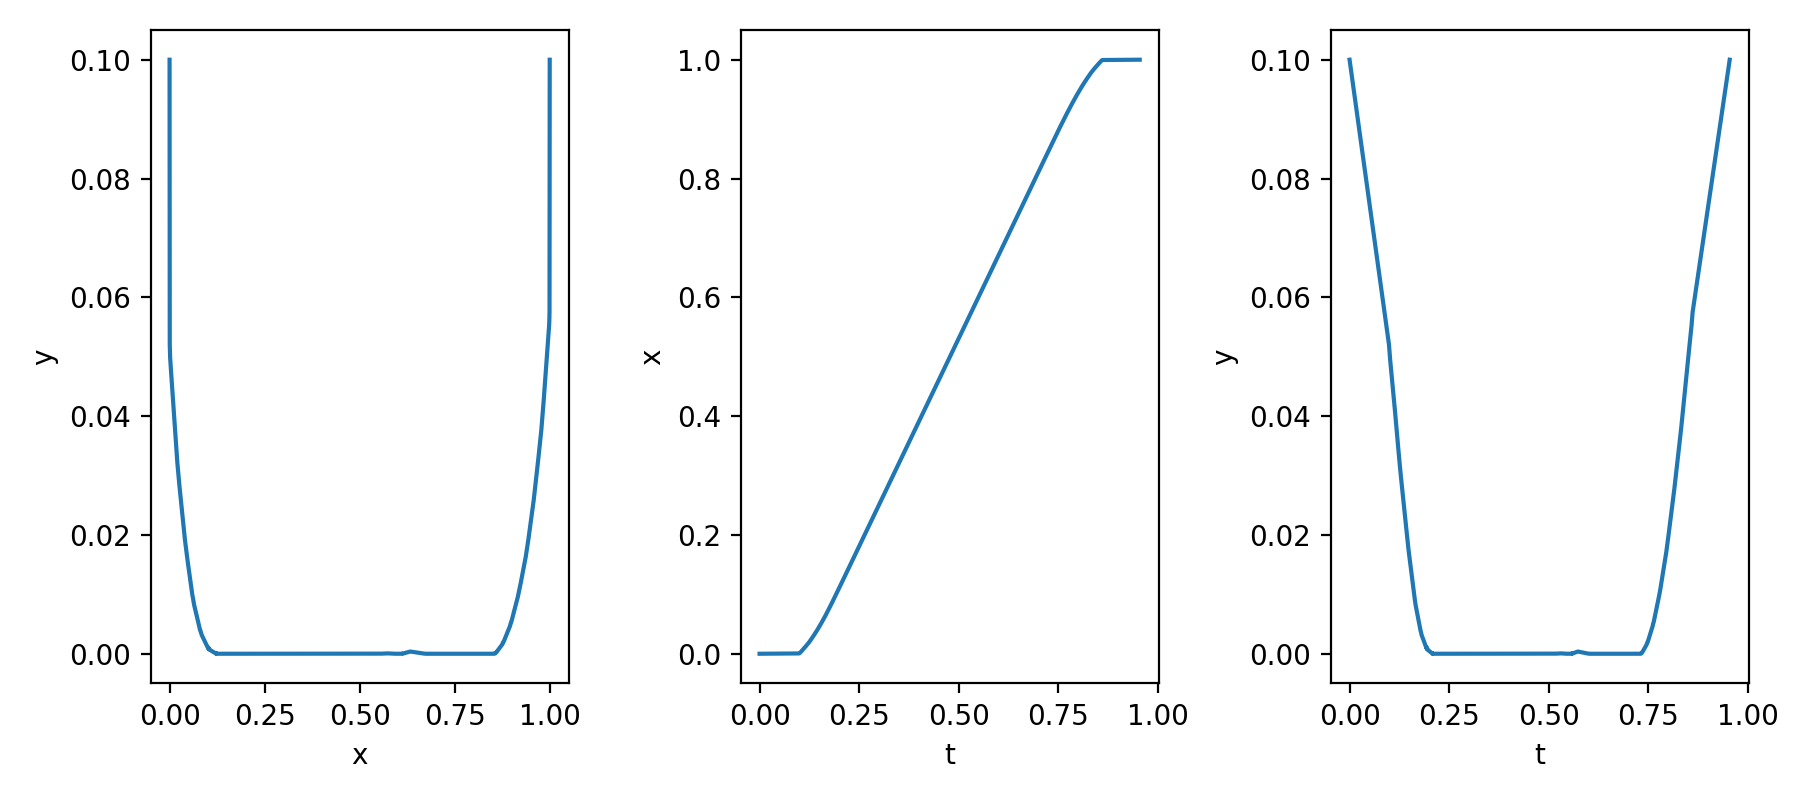

In [13]:
fig, axes = plt.subplot_mosaic("ABC", figsize=(9,4))
axes['A'].plot(ttxf[2], ttxf[3])
axes['A'].set_xlabel('x')
axes['A'].set_ylabel('y')
axes['B'].plot(ttxf[1], ttxf[2])
axes['B'].set_xlabel('t')
axes['B'].set_ylabel('x')
axes['C'].plot(ttxf[1], ttxf[3])
axes['C'].set_xlabel('t')
axes['C'].set_ylabel('y')
fig.tight_layout()

Looks pretty similar. Let's zoom in on the beginning.

<IPython.core.display.Javascript object>


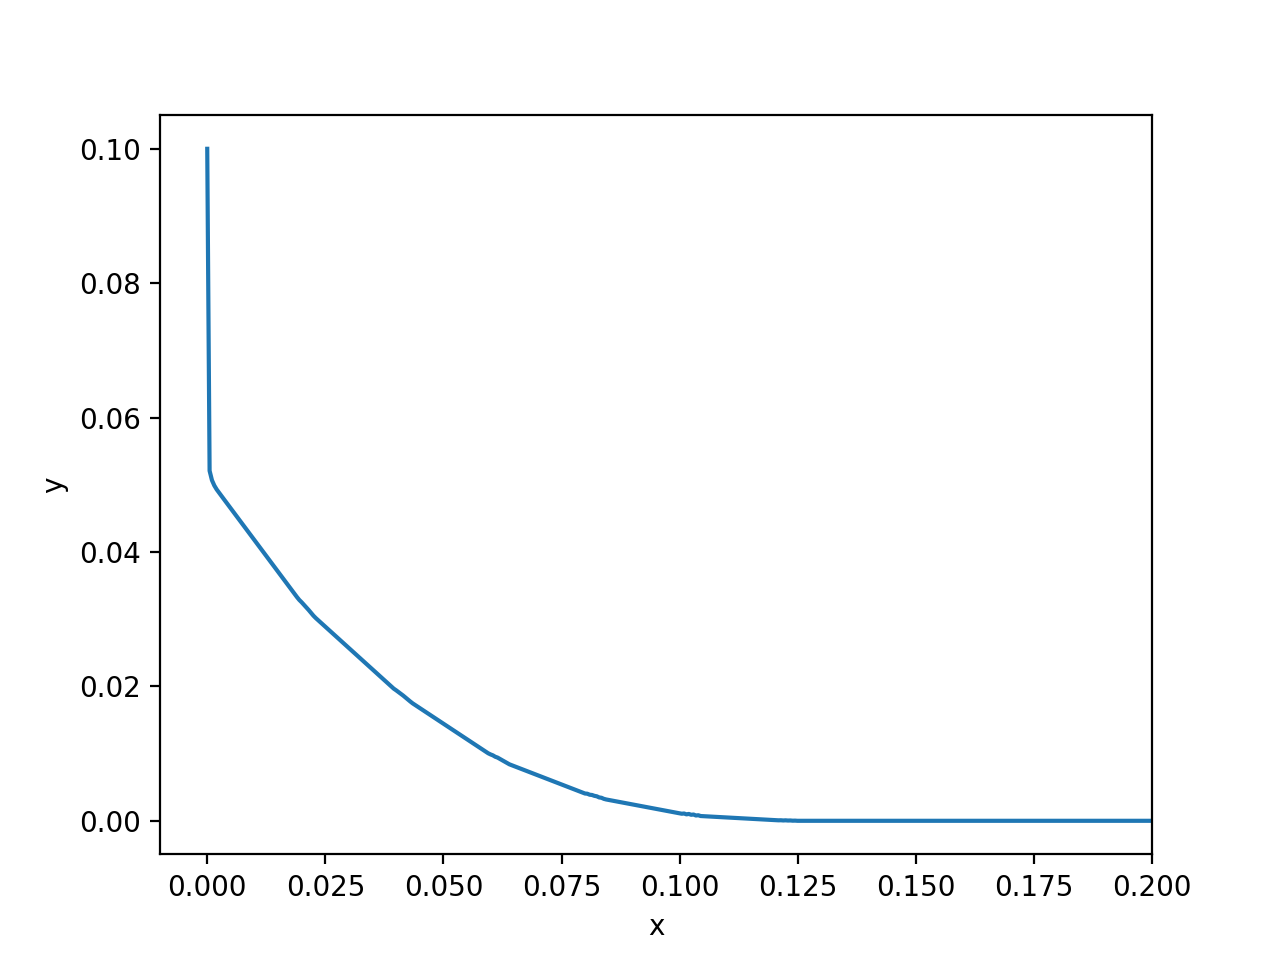

(-0.01, 0.2)

In [14]:
plt.plot(ttxf[2], ttxf[3])
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.01,0.2)

That looks remarkably like the first part is a straight vertical drop, followed by a smooth transition to the floor. I therefore made the ansatz that the correct solution is indeed a straight vertical drop, followed by a smooth function. After some wild experimentation, I found the following functional form worked well after the drop:
$$ f(x) = A \exp \left(-\frac{x}{A} \cosh\left(\frac{x}{B}\right) \right) $$

<IPython.core.display.Javascript object>


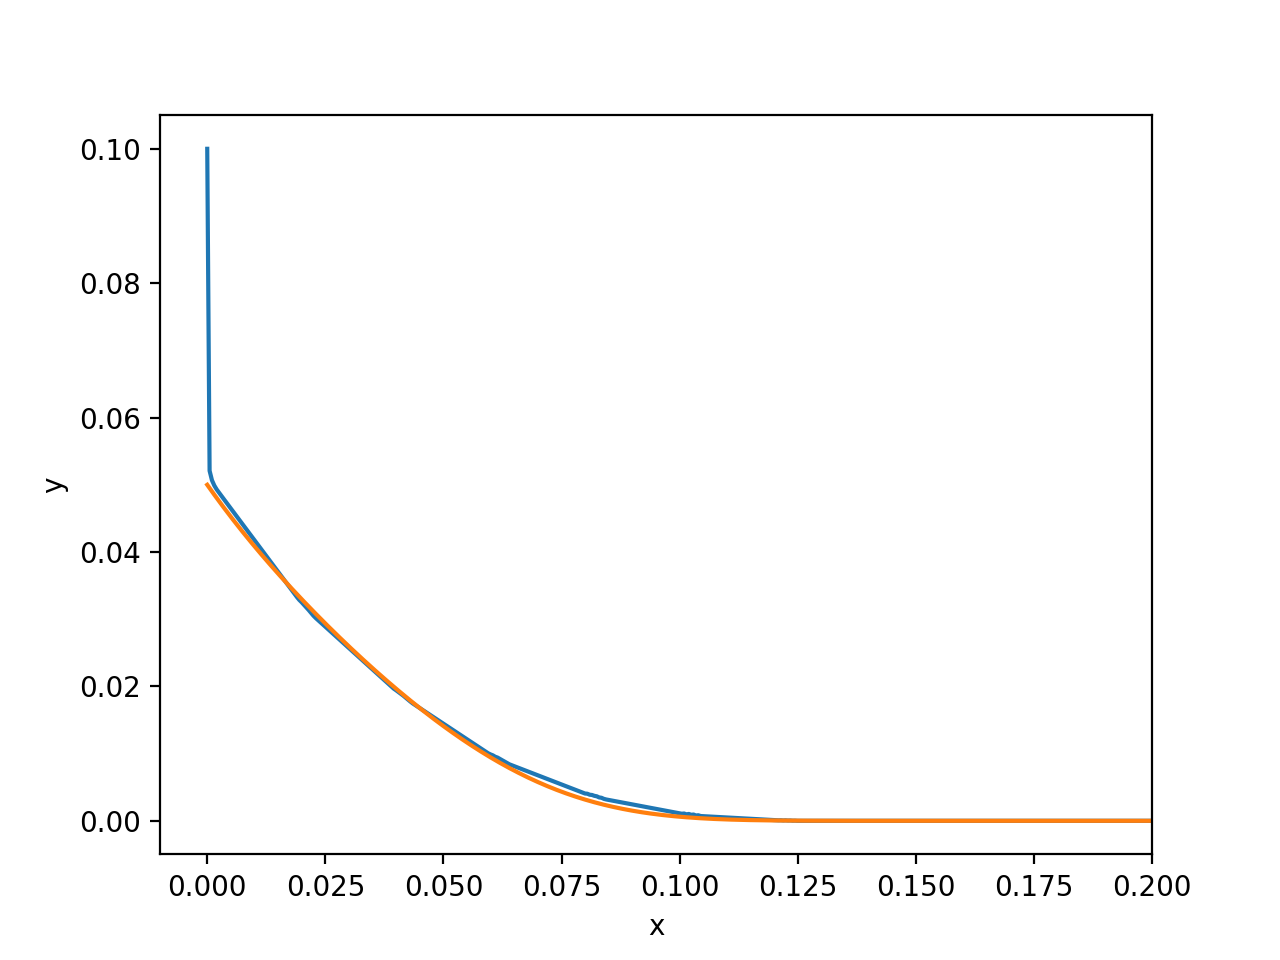

(-0.01, 0.2)

In [15]:
plt.plot(ttxf[2], ttxf[3], label='Numerical')

A = 0.05
B = 0.07
optf = A*np.exp(-ttxf[2]/A * np.cosh(-ttxf[2]/B))
plt.plot(ttxf[2], optf, label='Analytic')

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.01,0.2)

Assuming that functional form, I can now optimize for $A$ and $B$ to find the shortest time.

In [16]:
def time_for_analytic_form(AB, save=False):
    N = 2000
    # Just do first half and then reflect
    xg = np.linspace(0, 0.5, N)
    A = AB[0]
    B = AB[1]
    f = A * np.exp(-xg/A * np.cosh(xg/(B)))
    # Remove final value
    f = f[:-1]
    # Reflect for last half
    ffull = np.concatenate((f,f[::-1]))

    fulldt = find_time_interval(ffull)
    if save:
        return fulldt, ffull
    else:
        return fulldt

In [17]:
result = minimize(time_for_analytic_form, [0.05,0.07])

In [18]:
print(f"A={result.x[0]} B={result.x[1]}")
tottime, ffull = time_for_analytic_form(result.x, save=True)
ttxf = find_time_interval(ffull, savearrays=True)
ttxf_final = ttxf
print(f"time={tottime}")

A=0.08075583188750361 B=0.07718370210271103
time=0.9468403737532277


<IPython.core.display.Javascript object>


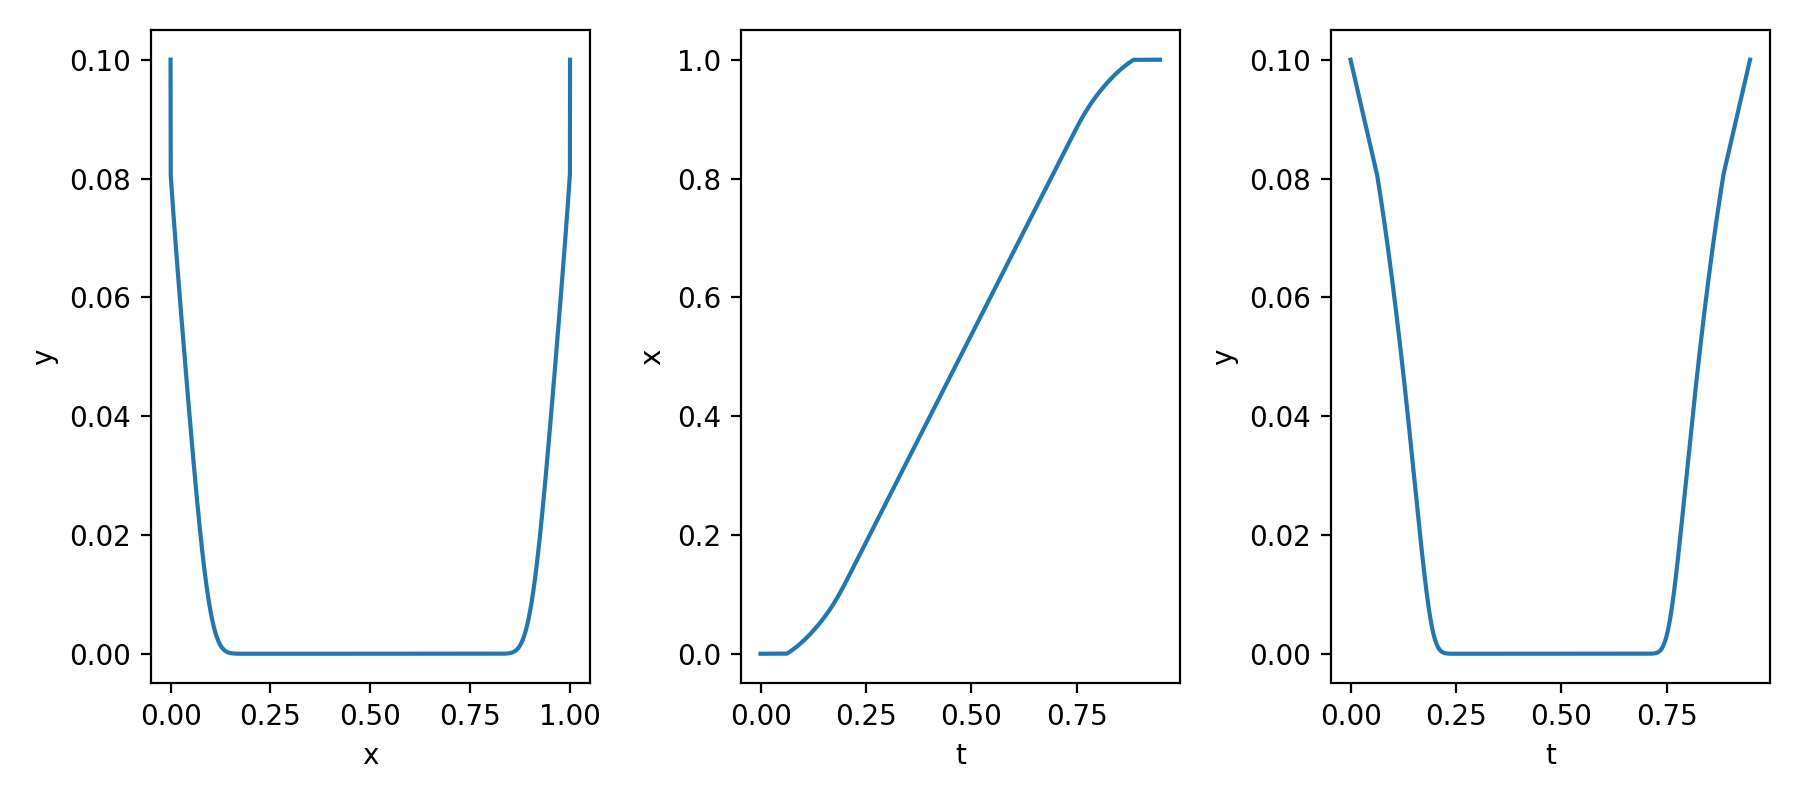

In [19]:
fig, axes = plt.subplot_mosaic("ABC", figsize=(9,4))
axes['A'].plot(ttxf[2], ttxf[3])
axes['A'].set_xlabel('x')
axes['A'].set_ylabel('y')
axes['B'].plot(ttxf[1], ttxf[2])
axes['B'].set_xlabel('t')
axes['B'].set_ylabel('x')
axes['C'].plot(ttxf[1], ttxf[3])
axes['C'].set_xlabel('t')
axes['C'].set_ylabel('y')
fig.tight_layout()

Going to my parametric form gained us about 0.007 seconds or about 0.7% (mainly from removing the tiny bump, I suspect). This form is pretty easy to deal with and gives a pretty well-optimized solution.

## Solution

The shape of the track $y=f(x)$ is given by

$$ f(x) = \begin{cases}  0.1 & x=0 \\ A \exp \left(-\frac{x}{A} \cosh\left(\frac{x}{B}\right) \right) & 0 < x \le 0.5 \\
A \exp \left(-\frac{1-x}{A} \cosh\left(\frac{1-x}{B}\right) \right)  & 0.5 < x < 1 \\ 0.1 & x=1 \end{cases} $$

with $A=0.08076$ and $B=0.07718$, which has a total time of 0.9468 seconds.

## Bonus: Movies!

In [20]:
from matplotlib.animation import FuncAnimation

Let's make movies of a few different courses for fun!

In [21]:
xg = np.linspace(0., 1.0, 50)
fsamples_parabola = 0.37*(xg-0.5)**2

ttxf_parabola = find_time_interval(fsamples_parabola, savearrays=True)

print(f"Total time: {ttxf_parabola[0]}")

Total time: 1.1709710875129475


In [22]:
fsamples_squarewell = np.array([0]*50)
ttxf_squarewell = find_time_interval(fsamples_squarewell, savearrays=True)
print(f"Total time: {ttxf_squarewell[0]}")

Total time: 0.9774293884635571


In [23]:
def setup_vars(dt, ttxflist):
    # Interpolate all arrays to desired dt.
    # Each argument is a sequence of length number of marbles, each of
    # which contains the array of that variable.
    
    t = [q[1] for q in ttxflist]
    x = [q[2] for q in ttxflist]
    y = [q[3] for q in ttxflist]
    vx = [q[4] for q in ttxflist]
        
    tott = [np.max(q) for q in t]
    longest_t = np.max(tott)
        
    # Resample
    tax = np.arange(0., longest_t+dt, dt)
    tnew = []
    xnew = []
    ynew = []
    vxnew = []
    for mi in range(len(t)):
        xinterp = interpolate.interp1d(t[mi], x[mi], bounds_error=False, fill_value=(0,1,))
        yinterp = interpolate.interp1d(t[mi], y[mi], bounds_error=False, fill_value=(0,0.1,))
        vxinterp = interpolate.interp1d(t[mi], vx[mi], bounds_error=False, fill_value=(vx[mi][0], vx[mi][-1],))
        
        tnew.append(tax)
        xnew.append(xinterp(tax))
        ynew.append(yinterp(tax))
        vxnew.append(vxinterp(tax))
    
    return tnew, xnew, ynew, vxnew

In [24]:
def setup_plot(fig, t, x, y, vx, color=['C0']):
    nmarbles = len(t)
    ax = fig.add_subplot(111)
    for mi in range(nmarbles):
        ax.plot(x[mi], y[mi], color=color[mi])
    vxmax = np.max(np.array(vx))
    
    # Set initial stuff
    marble = []
    for mi in range(nmarbles):
        marble.append( plt.plot(x[mi][0], y[mi][0], 'o', color=color[mi])[0] )

    return marble,

<IPython.core.display.Javascript object>


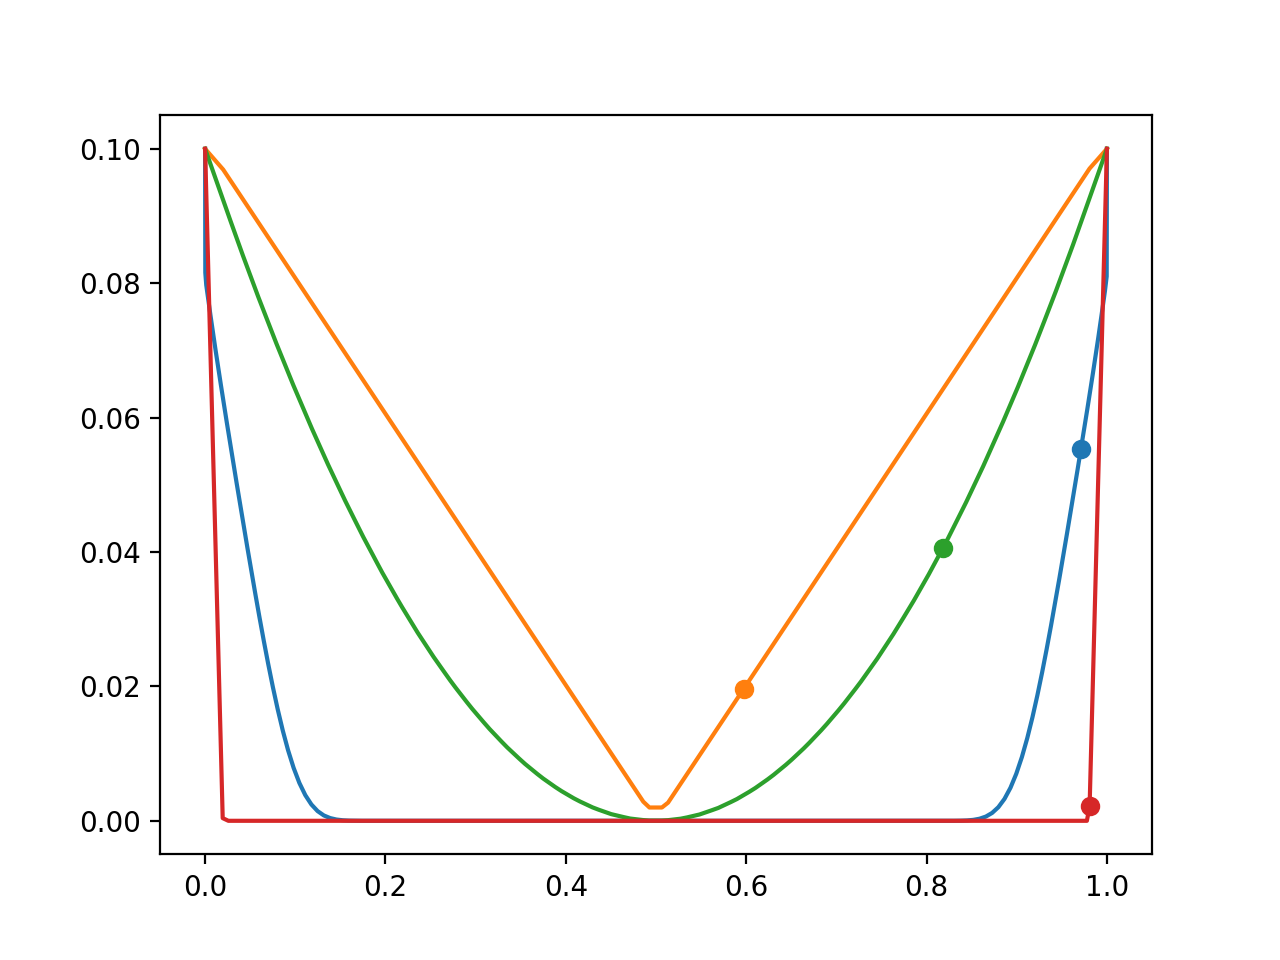

In [26]:
fig = plt.figure()

tnew, xnew, ynew, vxnew = setup_vars(0.005, [ttxf_final, ttxf_linear, ttxf_parabola, ttxf_squarewell])
nframes = len(tnew[0])
nmarbles = len(tnew)

def animate(i):
    for mi in range(nmarbles):
        marble[mi].set_data( [xnew[mi][i]], [ynew[mi][i]] )

    return marble,
    
marble, = setup_plot(fig, tnew, xnew, ynew, vxnew, color=['C0','C1','C2','C3'])
anim = FuncAnimation(fig, animate, frames=nframes, interval=10)
anim.save('marble-movie.mp4')